# Plasmid Design
---

Objectives:
- Learn how to create your first "Hello world" plasmid.
- Learn the benefits of doing this with code, which are, precise documentation and automation of design and validation.

Let us install some libraries first.
- [biopython](https://biopython.org): You already know this library from the Primer lecture.
- [dnaplotlib](https://github.com/VoigtLab/dnaplotlib): We also know this one, and will use it for plotting genetic constructs.
- [dna_features_viewer](https://edinburgh-genome-foundry.github.io/DnaFeaturesViewer/): A library by the Edinburgh Genome Foundry (University of Edinburgh) to visualize annotated DNA.
- [pydna](https://github.com/pydna-group/pydna): A library to plan cloning. See also the publication [Pereira, F., Azevedo, F., Carvalho, Â., Ribeiro, G. F., Budde, M. W., & Johansson, B. (BMC Bioinformatics, 2015)](https://doi.org/10.1186/s12859-015-0544-x).

In [33]:
# Uncomment the following lines to install required packages

# %pip install biopython
# %pip install dnaplotlib
# %pip install dna_features_viewer
# %pip install pydna

## Logging and Error Handling

Let's also add a simple logger for error handling. This is a useful alternative of decorating your code with `print("Error: ...")`. Instead we will be using `logger.error(...)`. This is not only more consistent in the form of the error messages, but also allows us to set the log level. For example, level `debug` will not be shown, while `info`, `warning`, `exception`, and `error` will be shown. Check out the [documentation about logging](https://docs.python.org/3/library/logging.html) to learn more about it.

In [34]:
import logging

# Simple logger setup
logger = logging.getLogger("plasmid")
logger.setLevel(logging.INFO)
logger.propagate = False

# Remove any existing handlers first
if logger.handlers:
    logger.handlers.clear()

# Add a StreamHandler
sh = logging.StreamHandler()
sh.setLevel(logging.INFO)
sh.setFormatter(logging.Formatter("[%(levelname)s] %(funcName)s: %(message)s"))
logger.addHandler(sh)


## The Design

We would like to write our first "Hello world" program for _E. coli_. The language in which we will be writing is DNA as this is directly understood by the bacterium as sequence of instructions.

While in Python, a "Hello world" program is a short `main.py` with `print("Hello world")`, we cannot (yet) make an _E. coli_ that displays the letters "Hello World".
And even if, this would be far from a very basic code - which is kind of the purpose of "hello world" programs. 
Let's choose a similarly simple task that is adapted to engineered bacteria: make the bacteria display a pink color!

There are several ways to write the DNA. The most direct one is to simply write the DNA directly. Typically this is out of reach for even simple programs like our one; and thus we exclude that directly.
The next, and perhaps most frequently taken approach, is to use a GUI-based DNA viewer where we can click together our DNA. This may be easy to start with, but has many downsides as we know from related tasks in computer science.
While learning how to code a computer may be nice to do with drag-and-dropping code pieces, we do not even see mildly complex code written in such languages.

Following the CS approach of writing code that writes other code, in case the latter is too complex to write directly, let us do the same.
We will thus use `Python` to write `DNA`.

This comes with other benefits:
- Anyone else that has our code can see and verify our design decisions.
- We can write code that may be not totally general for other constructs, but that can be adapted to them without too much effort.
- We can add powerful checks in our code. For example, we can check that a primer fulfills certain requirements and do not rely on the designer go to a website and enter the primers, there; which may be is skipped in a stressful week or by unexperienced designers.

Let us plot the design of our "Hello world" program first.
- We will choose a plasmid that will contain our program as extra DNA. This plasmid is called the backbone or vector.
- We want the _E. coli_ to be pink. Thus we need a promoter, an RBS, the CDS of a gene that codes for something pink, and a terminator.

Let's plot that design with the `dnaplotlib` library. 

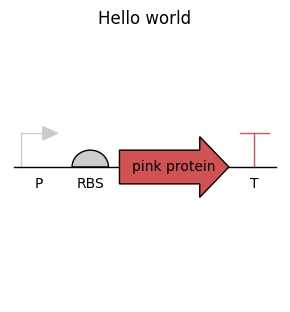

In [35]:
import dnaplotlib as dpl
from matplotlib import pyplot as plt
%matplotlib inline

# Create DNA renderer
dr = dpl.DNARenderer()
renderers = dr.SBOL_part_renderers()

# --- Define design ---
p0 = {
        'type': 'Promoter',
        'fwd': True,
        'opts': {
            'label':'P',
            'label_size':10,
            'label_y_offset': -5,
            'color':[0.8, 0.8, 0.8],
        },
    }
rbs0 = {
        'type': 'RBS',
        'fwd': True,
        'opts': {
            'label':'RBS',
            'label_size':10,
            'label_y_offset': -5,
            'color':[0.8, 0.8, 0.8],
        }
    }
cds0 = {
        'type': 'CDS',
        'fwd': True,
        'opts': {
            'color':[0.82, 0.32, 0.32],
            'label':'pink protein',
            'label_size':10
        },
    }
t0 = {
        'type': 'Terminator',
        'fwd': True,
        'opts': {
            'color':[0.82, 0.32, 0.32],
            'label':'T',
            'label_y_offset': -5,
            'label_size': 10
        },
    }

design = [
    p0, rbs0, cds0, t0,
]

# --- Render DNA ---
fig, ax = plt.subplots(figsize=(3, 3))

start_pos, end_pos = dr.renderDNA(
    ax=ax,
    parts=design,
    regs=[],
    part_renderers=renderers,
    reg_renderers= dr.std_reg_renderers(),
)

ax.set_xlim(start_pos - 1, end_pos + 1)
ax.set_ylim(-40, 40)
ax.set_axis_off()
plt.tight_layout()
plt.title("Hello world")
plt.show()

## The Backbone

For our construct we need to choose a backbone, also called vector.
This is the plasmid, a circular DNA, into which we will insert our construct.

We will choose a small and simple plasmid that is relatively empty and has some nice initial features.
It is one of the most researched plasmids in genetic engineering and is maintained in high copy number by our host, the bacteria _E. coli_.
The plasmid is called `pUC19`, starting with the usual `p` for plasmids and `UC` for University of California.
You can find some basic info on it on [Wikipedia](https://en.wikipedia.org/wiki/PUC19).

Since we will be coding our construct, we need to get the DNA sequence `pUC19`. There are many websites that offer this - and many formats to get DNA. While basic formats like [FASTA](https://en.wikipedia.org/wiki/FASTA_format) just contain a short description and the DNA sequence as letters `ATGC...`, more advanced formats allow the annotation of so called features - that is (lists of) subsequences - with a `type`, `description`, etc.
One such more verbose format is `GenBank` (`.gbk`).

Assuming that we get our plasmid from `addgene`, let's also get our sequence from them with the `url` specified below.


In [36]:
backbone_data = {
    "url": "https://media.addgene.org/snapgene-media/v3.0.0/sequences/222046/51c2cfab-a3b4-4d62-98df-0c77ec21164e/addgene-plasmid-50005-sequence-222046.gbk",
    "name": "pUC19",
}

Now we are ready to fetch the sequence and show some properties with `biopython`.

In [37]:
import urllib.request
from Bio import SeqIO, SeqRecord
from Bio.Seq import Seq, MutableSeq
import os
from pathlib import Path

def get_sequence(name: str, url: str) -> SeqRecord.SeqRecord:
    """Get a DNA sequence.
    
    Currently only supports GenBank files from URLs."""
    
    # Download the GenBank file if not already present
    sequence_path = Path("data") / f"{name}.gbk"
    if not os.path.exists(sequence_path):
        urllib.request.urlretrieve(url, sequence_path)
        logger.info(f"Downloaded {sequence_path}")
    else:
        logger.info(f"{sequence_path} already exists")

    # Load the plasmid using BioPython
    return SeqIO.read(sequence_path, "genbank")

# Get the backbone sequence
backbone = get_sequence(backbone_data['name'], backbone_data['url'])
assert backbone.seq is not None, "Failed to load backbone sequence"

# Display basic information about the plasmid
print(f"Description: {backbone.description}")
print(f"Sequence length: {len(backbone.seq)} bp")
print(f"Number of features: {len(backbone.features)}")

[INFO] get_sequence: data/pUC19.gbk already exists


Description: pUC cloning vector
Sequence length: 2686 bp
Number of features: 21


## Visualizing DNA

Next let's use `dna_features_viewer` to view the sequence. While `dna_features_viewer` provides some standard way of viewing sequences with a few commands, we opted for a little customization. For example, our sequence has features that are composed of multiple parts (subsequences) that may even wrap around in the plasmid. Also we would later like to draw only a subsequence. The standard plotting has some problems with this, so let's code a small wrapper.

In [38]:
from dna_features_viewer import GraphicFeature, CircularGraphicRecord, GraphicRecord
from typing import TypedDict, Literal, NamedTuple
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

# Define colors for feature types
feature_colors: dict[str,str] = {
    "promoter": "#FF7171",
    "CDS": "#7BEB7B",
    "terminator": "#6A6AF1",
    "RBS": "#F3F35F",
    "rep_origin": "#F378F3",
    "misc_feature": "#91F8F8",
    "protein_bind": "#FFA500",
}

# Provide a way to add extra features
# that are not in the sequence.
class ExtraFeature(TypedDict):
    start: int
    end: int
    strand: Literal[-1,1,0]
    label: str
    feature_type: str
    color: str

class CroppedFeature(NamedTuple):
    """Result of cropping a feature to a display window."""
    display_start: int
    display_end: int
    open_left: bool
    open_right: bool


def _crop_feature(
        start: int,
        end: int,
        from_to: tuple[int,int] | None,
        sequence_length: int = 0
    ) -> CroppedFeature | None:
    """Crop a feature to the display window. Returns None if completely outside.
    
    Parameters:
    -----------
    start, end : feature boundaries
    from_to : display window (start, end). start > end indicates wrap-around (circular).
    sequence_length : total sequence length (for wrap-around detection)
    """

    assert start <= end, "Feature start must be <= end"
    
    if from_to is None:
        return CroppedFeature(start, end, False, False)
    
    range_start, range_end = from_to
    is_wrap_around = range_start > range_end
    
    if is_wrap_around and sequence_length > 0:
        # Wrap-around case: window is [range_start, sequence_length) and [0, range_end)
        overlaps_first_part = not (end <= range_start or start >= sequence_length)
        overlaps_second_part = not (end <= 0 or start >= range_end)
        
        if not (overlaps_first_part or overlaps_second_part):
            return None
        
        # For wrap-around display, just return original coords
        open_left = (overlaps_first_part and start < range_start) or (overlaps_second_part and start < 0)
        open_right = (overlaps_first_part and end > sequence_length) or (overlaps_second_part and end > range_end)
        return CroppedFeature(start, end, open_left, open_right)
    else:
        # Normal (non-wrap-around) case
        if end <= range_start or start >= range_end:
            return None
        
        display_start = max(start, range_start)
        display_end = min(end, range_end)
        
        open_left = start < range_start
        open_right = end > range_end
        
        return CroppedFeature(display_start, display_end, open_left, open_right)


def plot_sequence(
        sequence: SeqRecord.SeqRecord,
        view_as_cycle: bool=False,
        figure_width: int=15,
        extra_features:list[ExtraFeature] | None = None,
        from_to: tuple[int,int] | None = None,
        plot_sequence: bool = False
    ) -> Axes | None:
    """Plot a sequence with features."""

    if sequence.seq is None:
        logger.error("required sequence.seq is missing")
        return None
    
    if view_as_cycle and from_to is not None:
        logger.error("from_to parameter cannot be used for circular plasmid plots")
        return None
    
    if from_to is None:
        from_to = (0, len(sequence.seq))

    # Check if positive integers
    assert from_to[0] >= 0 and from_to[1] >= 0, "from_to values must be non-negative integers"

    # Check if not trying to plot more than sequence length
    if from_to[0] <= from_to[1]:
        assert (from_to[1] - from_to[0]) <= len(sequence.seq), "Display window exceeds sequence length"
    else:
        assert (len(sequence.seq) - from_to[0] + from_to[1]) <= len(sequence.seq), "Display window exceeds sequence length"        

    first_index = from_to[0]
    # Handle wrap-around case: from_to[0] > from_to[1]
    if from_to[0] > from_to[1]:
        # Wrap-around: distance from start to end of sequence, plus start to from_to[1]
        sequence_length = (len(sequence.seq) - from_to[0]) + from_to[1]
    else:
        sequence_length = from_to[1] - from_to[0]
    
    # The features to plot
    graphic_features: list[GraphicFeature] = []

    # Add the extra features if provided
    if extra_features is not None:
        for extra_feature in extra_features:
            graphic_features.append(
                GraphicFeature(
                    start=extra_feature['start'],
                    end=extra_feature['end'],
                    strand=extra_feature['strand'],
                    label=extra_feature['label'],
                    feature_type=extra_feature['feature_type'],
                    color=extra_feature['color']
                )
            )

    for feature in sequence.features:
        feature_type: str = feature.type
        
        # Only include features that are in the color dictionary
        if feature_type in feature_colors:
            location = feature.location
            if location is None:
                continue
            strand = location.strand
            color = feature_colors[feature_type]
            name = f"{','.join(feature.qualifiers['label'])} ({feature.type})"
            
            # Handle compound locations (join) - add each part separately
            if hasattr(location, 'parts') and len(location.parts) > 1:
                # For compound locations in circular plasmids, add each part
                for i, part in enumerate(location.parts):
                    start = int(part.start)  # type: ignore
                    end = int(part.end)  # type: ignore
                    
                    # Only add label to the first part
                    label_text = name if i == 0 else None
                    
                    # Crop to display window
                    cropped = _crop_feature(start, end, from_to, len(sequence.seq))
                    if cropped is not None:                    
                        graphic_features.append(
                            GraphicFeature(
                                start=cropped.display_start,
                                end=cropped.display_end,
                                strand=strand,
                                label=label_text,
                                feature_type=feature_type,
                                color=color,
                                open_left=cropped.open_left,
                                open_right=cropped.open_right
                            )
                        )
            else:
                # For simple locations
                start = int(location.start)  # type: ignore
                end = int(location.end)  # type: ignore
                
                # Crop to display window
                cropped = _crop_feature(start, end, from_to, len(sequence.seq))
                if cropped is not None:
                    graphic_features.append(
                        GraphicFeature(
                            start=cropped.display_start,
                            end=cropped.display_end,
                            strand=strand,
                            label=name,
                            feature_type=feature_type,
                            color=color,
                            open_left=cropped.open_left,
                            open_right=cropped.open_right
                        )
                    )
    
    if view_as_cycle:
        record = CircularGraphicRecord(sequence_length=len(sequence.seq), features=graphic_features)
    else:
        # For linear view, GraphicRecord will automatically crop features to the window
        record = GraphicRecord(
            sequence=sequence.seq, 
            features=graphic_features, 
            first_index=first_index, 
            sequence_length=sequence_length
        )
    ax, _ = record.plot(figure_width=figure_width)
    if plot_sequence:
        fontdict = {"size": 11, "family": "monospace"}
        for i, base in enumerate(sequence.seq[first_index:first_index + sequence_length]):
            ax.text(
                first_index + i,
                -1.5,
                base,
                ha="center",
                va="center",
                fontdict=fontdict,
            )
    return ax

Great - we are ready to plot. Feel free to try the circular plot, too.

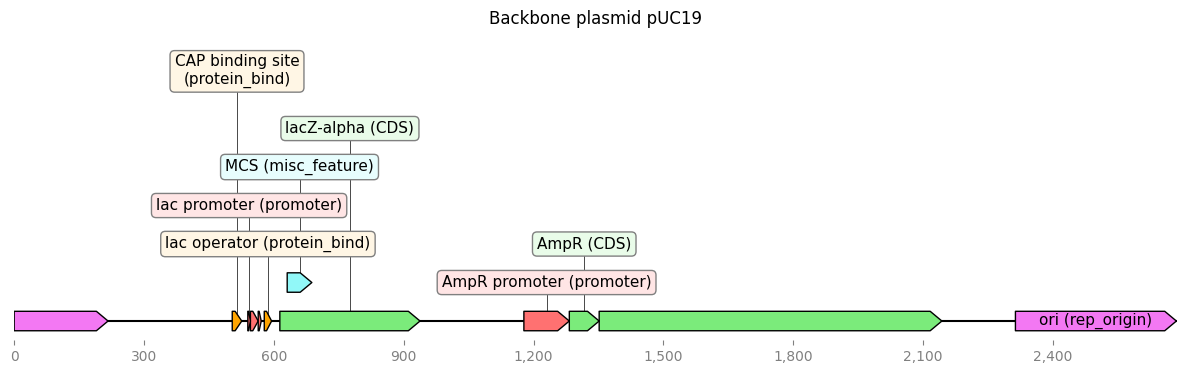

In [39]:
# view_as_cycle = True
view_as_cycle = False
ax = plot_sequence(backbone, view_as_cycle=view_as_cycle)
ax.set_title("Backbone plasmid pUC19");


We clearly see the features of two promoter regions (`promoter`) with the coding sequences (`CDS`), the origin of replication (`ori`), and a somewhat new feature called `MCS`.

What are the purposes of the two proteins that are expressed on the backbone:
- The `AmpR` construct (promoter and CDS are annotated) is responsible for expressing a beta-lactamase enzyme. This makes the bacterium resistant to the [antibiotic ampicillin](https://en.wikipedia.org/wiki/Ampicillin) (`amp`).
See also `blaTEM-1` in https://www.uniprot.org/uniprotkb/I1YAX3/entry (`bla` refers to `b`eta-`la`ctamase)

- The `lacZ-alpha` construct (promoter and CDS annotated) is responsible for expressing the LacZ-alpha fragment. In some _E. coli_ strains a part of the LacZ gene has been deleted: the LacZ-alpha part has been removed, while the LacZ-omega part remains in their genome. Deletions are annotated in strain names with a $\Delta$ followed by the type of deletion.
But why does the plasmid carry this fragment? This is used in [blue-white screening](https://en.wikipedia.org/wiki/Blue–white_screen): if grown on [X-gal](https://en.wikipedia.org/wiki/X-gal) and in presence of [IPTG](https://en.wikipedia.org/wiki/Isopropyl_β-D-1-thiogalactopyranoside), the bacteria that express this gene will be blue, while those that do not, remain white colonies on a plate.
As we know from a previous lecture IPTG acts as a repressor of a repressor: it binds to the lac repressor, inhibiting lac from binding the `lac operator` site (shown in the above figure).
Given this double repression, we can see IPTG as positively driving expression of downstream CDS.

We will also add the start codon for `lacZ-alpha` as a feature. This will be interesting for us later to remember where the CDS of this protein started.

In [40]:
from Bio.SeqFeature import SeqFeature, FeatureLocation

# Find the lacZ-alpha CDS start codon
lacz_cds = [f for f in backbone.features if f.type == "CDS" and "lacZ" in str(f.qualifiers.get("label", []))]

if not lacz_cds:
    logger.error("Cannot find lacZ")

# Get the start position of the lacZ CDS
lacz_start = int(lacz_cds[0].location.start)
    
# Check if start codon feature already exists to avoid duplicates
start_codon_exists = any(
    f.type == "misc_feature" and 
    "Start codon" in str(f.qualifiers.get("label", [])) 
    for f in backbone.features
)

if not start_codon_exists:
    # Add a feature for just the start codon (3 bp)
    start_codon_feature = SeqFeature(
        FeatureLocation(lacz_start, lacz_start + 3, strand=1),
        type="misc_feature",
        qualifiers={
            "label": ["Start codon (ATG)"],
            "note": ["lacZ-alpha start codon"]
        }
    )
    backbone.features.append(start_codon_feature)
    logger.info("Added start codon feature")
else:
    logger.info("Start codon feature already exists")

[INFO] <module>: Added start codon feature


We could even annotate more details in the sequence. For example, if we check out https://www.snapgene.com/plasmids/basic_cloning_vectors/lac_promoter then this even annotates the -35 and 10 regions of the lac promoter. We will not do this, here, but in general the more annotations you have in your sequence, the less likely you are to overwrite/clone into such sequences.

Also annotating is a good habit for checking the consistency. For example, we can check if the lac promoter corresponds to the one found at the source above, making us more confident about the part.

## Linearizing the Backbone

MCS stands for [Multiple cloning site](https://en.wikipedia.org/wiki/Multiple_cloning_site) and is also often referred to as a polylinker. It is a region with lots of restriction sites that occur nowhere else on the plasmid.
This makes it easy to cut it open and insert another fragment at this site.

As we see in the figure before, the `MCS` is in the middle (or rather beginning) of the `lacZ-alpha` CDS. This is not a coincidence, but a key idea in blue-white screening. If we cut in the MCS and successfully insert a gene there, we will destroy the original `lacZ-alpha` CDS. In presence of X-Gal and IPTG, the colonies with successful inserts will thus be white (unless we make them pink as we plan to) and not blue anymore.

Let's look at the MCS feature in more detail.

In [41]:
# Identify the MCS feature
MSC_feature = [feature for feature in backbone.features if feature.type == "misc_feature"][0]
print(f"# MSC feature:\n{MSC_feature}")
MSC_feature_seq = MSC_feature.extract(backbone.seq)

# MSC feature:
type: misc_feature
location: [631:688](+)
qualifiers:
    Key: label, Value: ['MCS']
    Key: note, Value: ['pUC18/19 multiple cloning site']



`biopython` comes with a really useful library of restriction enzymes, where we can search for restriction sites and simulate cuts. Let's do this within the MCS for a list of frequently used enzymes.

We also code a function `get_enzymes_only_in_feature` to obtain a list of enzymes that cut only within the MCS and not somewhere else in the plasmid.

In [42]:
from Bio.Restriction import AllEnzymes, RestrictionBatch
from Bio.Restriction.PrintFormat import PrintFormat


def get_enzymes_only_in_feature(feature) -> dict[str, list[int]]:
    """Get restriction enzymes that cut within a feature."""
    enzymes: dict[str, list[int]] = {}
    enzymes_cutting_outside: list[str] = []
    feature_start = int(feature.location.start)
    feature_end = int(feature.location.end)
    
    # Check cut sites for all enzymes
    for enzyme in AllEnzymes:
        name = enzyme.__name__
        cut_sites = enzyme.search(backbone.seq)
        for site in cut_sites:
            if feature_start <= site < feature_end:
                if name not in enzymes:
                    enzymes[name] = []
                enzymes[name].append(site)
            else:
                enzymes_cutting_outside.append(name)

    # Remove enzymes that cut outside the feature
    for enzyme_name in set(enzymes_cutting_outside):
        if enzyme_name in enzymes:
            del enzymes[enzyme_name]

    return enzymes


# Find enzymes that cut only within the MCS
enzymes_only_in_MCS = get_enzymes_only_in_feature(MSC_feature)
print(f"# Enzymes cutting only within MCS:\n{list(enzymes_only_in_MCS.keys())}\n")

# Example: Print cut sites for EcoRI
ecoRI_sites = enzymes_only_in_MCS.get("EcoRI", [])
print(f"# EcoRI cut sites within MCS:\n{ecoRI_sites}\n")

# show cuttings for some
batch_in_lab = ['EcoRI', 'BamHI', 'HindIII', 'KpnI', 'XbaI', 'PstI']
batch_safe = [ enzyme for enzyme in batch_in_lab if enzyme in enzymes_only_in_MCS ]

print(f"# Cut sites for selected safe enzymes {batch_safe}:")
restriction_batch = RestrictionBatch(batch_safe)
result = restriction_batch.search(MSC_feature_seq)
my_map = PrintFormat()
my_map.sequence = MSC_feature_seq  # type: ignore
my_map.print_as("map")
my_map.print_that(result)


# Enzymes cutting only within MCS:
['BveI', 'ApoI', 'AcsI', 'BmeT110I', 'XapI', 'FriOI', 'BanII', 'SstI', 'XmiI', 'KpnI', 'SphI', 'BspMI', 'Ama87I', 'BspMAI', 'AccI', 'FblI', 'SpnRII', 'HincII', 'EcoICRI', 'BsiHKCI', 'BfuAI', 'EcoT38I', 'Asp718I', 'HindIII', 'Eco88I', 'Ecl136II', 'PstI', 'BamHI', 'Hso63373III', 'EcoRI', 'BsoBI', 'Eco24I', 'Nli3877I', 'Acc65I', 'AvaI', 'Sse8387I', 'HgiJII', 'Cfr9I', 'XmaI', 'PgaP73III', 'XbaI', 'HindII', 'Eco53kI', 'SdaI', 'TspMI', 'Asl11923II', 'Acc36I', 'SbfI', 'Bps6700III', 'Psp124BI', 'SmaI', 'SacI', 'PaeI', 'SalI', 'BscXI']

# EcoRI cut sites within MCS:
[684]

# Cut sites for selected safe enzymes ['EcoRI', 'BamHI', 'HindIII', 'KpnI', 'XbaI', 'PstI']:
 2 HindIII
 |                                                          
 |               18 PstI
 |               |                                          
 |               |       26 XbaI
 |               |       |                                  
 |               |       |     32 BamHI
 |       

Let's mark the sites of two widely used restriction enzymes, [EcoRI](https://en.wikipedia.org/wiki/EcoRI) and [BamHI](https://en.wikipedia.org/wiki/BamHI), in the plasmid map and zoom into the MSC region.

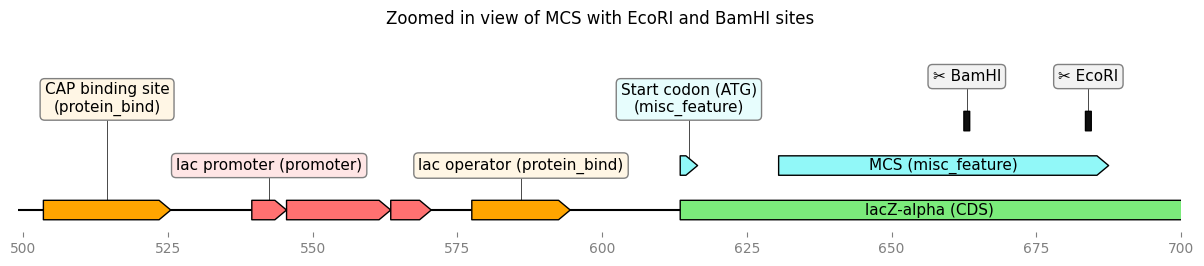

In [43]:
ecoRI_sites = enzymes_only_in_MCS.get("EcoRI", [])
extra_features = [
    ExtraFeature(
        start=site,
        end=site + 1,
        strand=0,
        label="✂️ EcoRI",
        feature_type="restriction_site",
        color="#0F0F0F"
    ) for site in ecoRI_sites]

bamHI_sites = enzymes_only_in_MCS.get("BamHI", [])
extra_features += [
    ExtraFeature(
        start=site,
        end=site + 1,
        strand=0,
        label="✂️ BamHI",
        feature_type="restriction_site",
        color="#0F0F0F"
    ) for site in bamHI_sites]

# And show a crop around the MCS with the promotor upstream
ax = plot_sequence(backbone, view_as_cycle=view_as_cycle, extra_features=extra_features, from_to=(500, 700))
ax.set_title("Zoomed in view of MCS with EcoRI and BamHI sites");


We promised before that `biopython` cannot only find cut sites but also simulate cutting, including sticky ends with 3' and 5' overhangs. Let's do this for the two enzymes to see their cutting behavior. We code a function `visualize_restriction_cut` for that purpose.

In [44]:
from Bio.Restriction import RestrictionBatch

def visualize_restriction_cut(enzyme, sequence: Seq | MutableSeq | str | None, show_context_bp: int | None = None) -> None:
    """Visualize a restriction enzyme cut with overhangs in ASCII art.
    
    Parameters:
    -----------
    enzyme : RestrictionType enzyme object or str
        Either the enzyme name as a string (e.g., 'EcoRI') or enzyme object
    sequence : Seq or MutableSeq or str or None
        The DNA sequence to visualize (will find cut sites in this sequence)
    show_context_bp: int or None
        If not None, then the +/- context window from the cut is shown.
    """
    
    # If enzyme is a string, get the enzyme object
    if isinstance(enzyme, str):
        enzyme_batch = RestrictionBatch([enzyme])
        enzyme_rt = list(enzyme_batch)[0]
    else:
        enzyme_rt = enzyme
    
    site = enzyme_rt.site  # type: ignore
    ovhg = enzyme_rt.ovhg  # type: ignore
    fst5 = enzyme_rt.fst5  # type: ignore
    fst3 = enzyme_rt.fst3  # type: ignore
    
    print(f"\n✂️ {enzyme_rt.__name__}")
    site_display = site[:fst5] + '|' + site[fst5:]
    print(f"Cut position: {site_display}")
    print(f"Overhang: {ovhg} (negative = 5' overhang, positive = 3' overhang)")
    print()
    
    # Convert to Seq if string
    sequence = enzyme_rt.site if sequence is None else sequence
    seq_obj = Seq(sequence) if isinstance(sequence, str) else sequence
    
    # Find all cut sites in the sequence
    cut_sites = enzyme_rt.search(seq_obj)
    if not cut_sites:
        print(f"No cut sites found.")
        return
    
    # Show each cut site with context
    for i, cut_pos in enumerate(cut_sites, 1):
        print(f"Cut site {i} at position {cut_pos}:")
        
        # BioPython uses 1-based indexing, Python uses 0-based
        # search() returns the 1-based position after the forward strand cut
        # To get the 0-based site start: (search_result - 1) - fst5
        site_start = cut_pos - 1 - fst5
        site_end = site_start + len(site)
        
        # Get context around the cut
        if show_context_bp is not None:
            context_start = max(0, cut_pos - show_context_bp)
            context_end = min(len(seq_obj), cut_pos + show_context_bp)
        else:
            context_start = 0
            context_end = len(seq_obj)
        context = seq_obj[context_start:context_end]
        
        # Position of the site start within the context
        site_start_in_context = site_start - context_start
        site_end_in_context = site_start_in_context + len(site)
        
        # Get reverse complement
        rev_comp = str(context.reverse_complement())
        
        # Calculate cut positions within the context
        # fwd_cut_pos: position where forward strand is cut
        fwd_cut_pos = site_start_in_context + fst5
        
        # For reverse strand: positions are mirrored because of antiparallel nature
        # rev_cut_pos in the reverse complement string is calculated as:
        rev_cut_pos = len(rev_comp) - (site_end_in_context + fst3)
        
        # Split around the cuts
        fwd_left = str(context[:fwd_cut_pos])
        fwd_right = str(context[fwd_cut_pos:])
        
        # For reverse strand, we need to reverse it for display (3' to 5' direction)
        rev_comp_rev = rev_comp[::-1]
        rev_cut_pos_rev = len(rev_comp_rev) - rev_cut_pos
        
        rev_left = rev_comp_rev[:rev_cut_pos_rev]
        rev_right = rev_comp_rev[rev_cut_pos_rev:]
        
        # For visualization, add spaces to show the overhang gap
        gap_size = abs(ovhg)
        gap = ' ' * (gap_size + 1)

        fwd_cut = fwd_left + gap + fwd_right
        rev_cut = rev_left + gap + rev_right
        
        print("  5'- " + fwd_cut + " -3'")
        print("  3'- " + rev_cut + " -5'")
        print()

# Using enzyme name as string with the MCS sequence
visualize_restriction_cut("EcoRI", backbone.seq, show_context_bp=30)
visualize_restriction_cut("BamHI", backbone.seq, show_context_bp=30)
# visualize_restriction_cut("SmaI", backbone.seq, show_context_bp=30)
# visualize_restriction_cut("KpnI", backbone.seq, show_context_bp=30)



✂️ EcoRI
Cut position: G|AATTC
Overhang: -4 (negative = 5' overhang, positive = 3' overhang)

Cut site 1 at position 684:
  5'- CTCTAGAGGATCCCCGGGTACCGAGCTCG     AATTCACTGGCCGTCGTTTTACAACGTCGTG -3'
  3'- GAGATCTCCTAGGGGCCCATGGCTCGAGCTTAA     GTGACCGGCAGCAAAATGTTGCAGCAC -5'


✂️ BamHI
Cut position: G|GATCC
Overhang: -4 (negative = 5' overhang, positive = 3' overhang)

Cut site 1 at position 663:
  5'- GCTTGCATGCCTGCAGGTCGACTCTAGAG     GATCCCCGGGTACCGAGCTCGAATTCACTGG -3'
  3'- CGAACGTACGGACGTCCAGCTGAGATCTCCTAG     GGGCCCATGGCTCGAGCTTAAGTGACC -5'



Both look great with similar cutting characteristics. There is no strong preference there: `EcoRI` is perhaps the most commonly used one in labs and `BamHI` is a little closer to the upstream promoter and may thus result in better efficiency in expression. Let's choose `EcoRI`.

In [45]:
from Bio.Restriction import EcoRI

# Cut the (circular) backbone with EcoRI
cut_backbone = EcoRI.catalyze(backbone.seq)

# This results in a single fragment
assert len(cut_backbone) == 2

If we cut with `EcoRI` this will produce sticky ends with overhangs. However the Gibson Master Mix contains a 5'-exonuclease that chews back DNA from the 5' ends. This will remove the overhangs (and even chew way further), resulting in 3' overhangs.

For our insert to anneal to the two ends of the linearized backbone, we need to create homology arms for the insert that match the contexts of the cut sites. Typically these arms need to be of length around 20 nt for Gibson with a single (or few) inserts.

Let us first show the cut sites with blunt ends (after some chewing).

In [46]:
homology_length = 20
print(f"We aim for homology arms of length {homology_length}.")
print()

print("Upstream: before the cut site and after chewing back the 5' overhang")
cut_backbone_left = cut_backbone[0][-homology_length:]
print("5'- ..." + cut_backbone_left)
print("3'- ..." + cut_backbone_left.complement())
print()

chew_back_5prime = -EcoRI.ovhg
cut_backbone_right = cut_backbone[1][chew_back_5prime:chew_back_5prime+homology_length]
print("Downstream: after the cut site and after chewing back the 5' overhang")
print(cut_backbone_right + "... -3'")
print(cut_backbone_right.complement() + "... -5'")

We aim for homology arms of length 20.

Upstream: before the cut site and after chewing back the 5' overhang
5'- ...ATCCCCGGGTACCGAGCTCG
3'- ...TAGGGGCCCATGGCTCGAGC

Downstream: after the cut site and after chewing back the 5' overhang
CACTGGCCGTCGTTTTACAA... -3'
GTGACCGGCAGCAAAATGTT... -5'


While we show blunt ends, the 5' ends will be chewed back even further. For the insert, we need to complement the template (= bottom) strand. Thus we can use the bases from `-homology_length` to `0` (relative to the cut) of the coding (=top) strand for the left arm.

Likewise, the right cut starts after the overhang for `homology_length` nt.

In [47]:
left_homology = cut_backbone_left
assert len(left_homology) == homology_length

right_homology = cut_backbone_right
assert len(right_homology) == homology_length

print("Homology arms that we need to add to the insert:")
print(left_homology, " + (insert) + ", right_homology)

Homology arms that we need to add to the insert:
ATCCCCGGGTACCGAGCTCG  + (insert) +  CACTGGCCGTCGTTTTACAA


### Part 1: The RBS

Ribosome binding sites (RBSes) are DNA sequences that are transcribed to RNA that binds tightly to part of the Ribosome. By analyzing many such sequences and looking at the statistics of most common bases, so-called consensus sequences have been obtained.
For the RBS this is the famous [Shine-Dalgarno sequence](https://en.wikipedia.org/wiki/Shine–Dalgarno_sequence).
In _E. coli_ the RNA sequence is `AGGAGGU` (corresponding to `AGGAGGT` in DNA).

Once we have chosen our RBS, when designing our insert, we need to know how to add our CDS after the RBS.
Luckily this has been studied. An important parameter for the translation initiation rate is the spacing between the RBS and the start codon of the CDS. A systematic study was done by [Hongyun Chen,  Matthew Bjerknes,  Ravindra Kumar,  Ernest Jay, NAR 1994](https://doi.org/10.1093/nar/22.23.4953). They found that 5 nt was optimal.

> __*Side note:*__ How does the Ribosome determine the open reading frame (ORF)? It scans for a start codon like `AUG` on the RNA (`ATG` in DNA) which then sets the reading frame (determining the codons). However, central to this is the distance of the Shine-Dalgarno to the possible start of the ORF. As noted before, 5 nt is optimal.

All these findings have been systematically included into a tool by
[Salis, Mirsky, Voigt (Nat Biotechnol. 2009)](https://pmc.ncbi.nlm.nih.gov/articles/PMC2782888/).
Besides binding of the Shine-Dalgarno sequence and spacing, the authors also identify the standby site upstream of the Shine-Dalgarno sequence as central for the translation initiation rate.
Figure 1 in their article shows the standby site, the Shine-Dalgarno sequence, spacing, and the start codon nicely in relation to the Ribosome that interacts with them.

#### Choosing an RBS

We will choose a relatively strong RBS that is frequently used in synthetic designs: it is part `BBa_B0034` from https://parts.igem.org/Ribosome_Binding_Sites/Prokaryotic/Constitutive/Community_Collection.

It already contains the standby site, the Shine-Dalgarno sequence, spacing, and the start codon: `TCTAGAG` + `AAAGAGGAGAAA` + `TACTAG` + `ATG`

Let's create an annotated sequence `rbs` for the RBS.

In [48]:
from Bio.SeqRecord import SeqRecord
rbs_standby = Seq("TCTAGAG")
rbs_shine_dalgarno = Seq("AAAGAGGAGAAA")
rbs_spacer = Seq("TACTAG")
rbs_seq = rbs_standby + rbs_shine_dalgarno + rbs_spacer

rbs = SeqRecord(rbs_seq, name="RBS_BBa_B0034")
rbs_features = [
    SeqFeature(
        FeatureLocation(0, len(rbs_seq), strand=1),
        type="RBS",
        qualifiers={
            "label": ["BBa_B0034"],
            "note": ["new RBS"]
        }
    ),
    SeqFeature(
        FeatureLocation(len(rbs_standby), len(rbs_standby + rbs_shine_dalgarno), strand=1),
        type="misc_feature",
        qualifiers={
            "label": ["Shine-Dalgarno"],
            "note": ["Shine-Dalgarno sequence"]
        }
    ),
]
rbs.features.extend(rbs_features)

### Part 2: The Pink CDS

We want our _E. coli_ to be pink. A promising CDS is the `mCherry CDS` sequence, that we find, for example, at https://www.ncbi.nlm.nih.gov/protein/AAV52164.1

Let's get this sequence, annotate it, and check translation: it should start with the usual `M` (or Met) for [Methionine](https://en.wikipedia.org/wiki/Methionine) and stop with the stop codon shown as `*`. While most translation processes start with this amino acid, it is often cleaved after translation, with the final protein not starting with it.

In [49]:
from Bio import Entrez, SeqIO
from Bio.SeqFeature import SeqFeature, FeatureLocation
from pprint import pprint

accession = "AY678264"  # mCherry gene
email = "contact@biodis.co"

with Entrez.efetch(db="nucleotide", id=accession, rettype="fasta", retmode="text", email=email) as handle:
    cds = SeqIO.read(handle, "fasta")
    
# Add a CDS feature annotation
cds_feature = SeqFeature(
FeatureLocation(0, len(cds.seq), strand=1),  # Start to end, forward strand
    type="CDS",
    qualifiers={
        "label": ["mCherry"],
        "product": ["mCherry fluorescent protein"],
        "note": ["Red fluorescent protein"]
    }
)
cds.features.append(cds_feature)

print("Translation")
print('DNA:', cds.seq)
print('Protein:', cds.seq.translate())

Translation
DNA: ATGGTGAGCAAGGGCGAGGAGGATAACATGGCCATCATCAAGGAGTTCATGCGCTTCAAGGTGCACATGGAGGGCTCCGTGAACGGCCACGAGTTCGAGATCGAGGGCGAGGGCGAGGGCCGCCCCTACGAGGGCACCCAGACCGCCAAGCTGAAGGTGACCAAGGGTGGCCCCCTGCCCTTCGCCTGGGACATCCTGTCCCCTCAGTTCATGTACGGCTCCAAGGCCTACGTGAAGCACCCCGCCGACATCCCCGACTACTTGAAGCTGTCCTTCCCCGAGGGCTTCAAGTGGGAGCGCGTGATGAACTTCGAGGACGGCGGCGTGGTGACCGTGACCCAGGACTCCTCCCTGCAGGACGGCGAGTTCATCTACAAGGTGAAGCTGCGCGGCACCAACTTCCCCTCCGACGGCCCCGTAATGCAGAAGAAGACCATGGGCTGGGAGGCCTCCTCCGAGCGGATGTACCCCGAGGACGGCGCCCTGAAGGGCGAGATCAAGCAGAGGCTGAAGCTGAAGGACGGCGGCCACTACGACGCTGAGGTCAAGACCACCTACAAGGCCAAGAAGCCCGTGCAGCTGCCCGGCGCCTACAACGTCAACATCAAGTTGGACATCACCTCCCACAACGAGGACTACACCATCGTGGAACAGTACGAACGCGCCGAGGGCCGCCACTCCACCGGCGGCATGGACGAGCTGTACAAGTAA
Protein: MVSKGEEDNMAIIKEFMRFKVHMEGSVNGHEFEIEGEGEGRPYEGTQTAKLKVTKGGPLPFAWDILSPQFMYGSKAYVKHPADIPDYLKLSFPEGFKWERVMNFEDGGVVTVTQDSSLQDGEFIYKVKLRGTNFPSDGPVMQKKTMGWEASSERMYPEDGALKGEIKQRLKLKDGGHYDAEVKTTYKAKKPVQLPGAYNVNIKLDITSHNEDYTIVEQYERAEGRHSTGGMDELYK*


Indeed we find the start codon `ATG` at the beginning being translated to `M` and the stop codon at the end.

### Part 3: The Terminator

We will choose a strong double terminator `BBa_B0015` from https://parts.igem.org/Part:BBa_B0015

In [50]:
terminator_seq = Seq("ccaggcatcaaataaaacgaaaggctcagtcgaaagactgggcctttcgttttatctgttgtttgtcggtgaacgctctctactagagtcacactggctcaccttcgggtgggcctttctgcgtttata")
terminator = SeqRecord(terminator_seq, name="BBa_B0015")
terminator_feature = SeqFeature(
    FeatureLocation(0, len(terminator_seq), strand=1),
    type="terminator",
    qualifiers={
        "label": ["BBa_B0015"],
        "note": ["Double terminator"]
    }
)
terminator.features.append(terminator_feature)

### Gluing the Insert together

We are now ready to construct the DNA sequence from the parts via:

In [51]:
insert = left_homology + rbs + cds + terminator + right_homology

And let's look at the insert as a whole

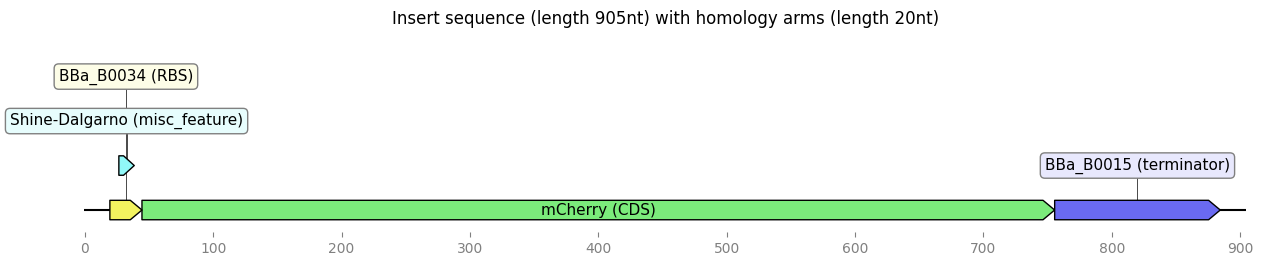

In [52]:
ax = plot_sequence(insert, view_as_cycle=False)
ax.set_title(f"Insert sequence (length {len(insert.seq)}nt) with homology arms (length {homology_length}nt)");

## The Gibson Assembly

Next comes the big step: we will simulate a Gibson assembly and check if the construct is what we expected. Let's code this with the help of `pydna`.

In [53]:
import pydna
from pydna.assembly2 import Assembly
from pydna.dseqrecord import Dseqrecord

backbone_dseq = Dseqrecord(backbone, name="backbone", circular=True)
cutting = backbone_dseq.cut(EcoRI)
backbone_linearized_dseq = cutting[0]

# The insert
insert_dseq = Dseqrecord(insert, name="insert", circular=False)

fragments = [
    backbone_linearized_dseq,
    insert_dseq,
]
asm = Assembly(fragments, limit=10)
products = asm.assemble_circular()
final_construct = products[0]

Of particular interest is the sequence from the promoter to the start codon of the new CDS. We will show this and check if it looks unexpected.

type: promoter
location: [2543:2574](+)
qualifiers:
    Key: label, Value: ['lac promoter']
    Key: note, Value: ['promoter for the E. coli lac operon']



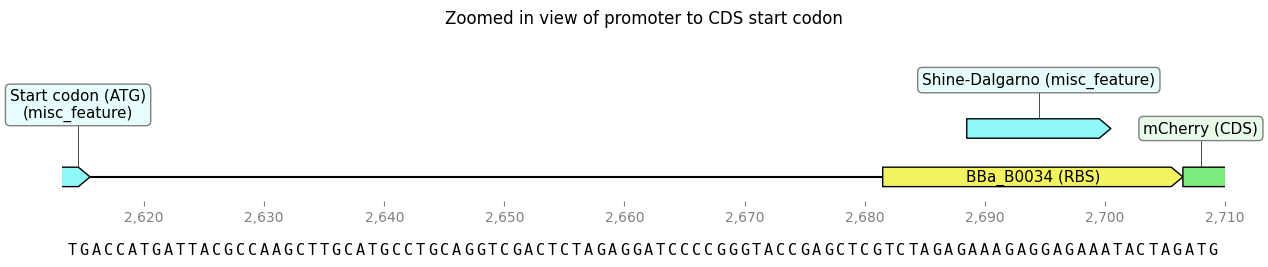

In [54]:
promoters = [ f for f in backbone_linearized_dseq.features if f.type == "promoter" ]
promoter = promoters[1]
print(promoter)

ax = plot_sequence(final_construct, view_as_cycle=view_as_cycle, from_to=(2560+54, 2710), plot_sequence=True)
ax.set_title("Zoomed in view of promoter to CDS start codon");

We see that between the lac operator and our RBS there is already the original start codon from the CDS that we cut. That means there was probably also an RBS between the lac operator and this `ATG`. Ribosomes may thus already start translating there. While this is not a clean design to just add our RBS and `ATG` afterwards, we will go for this as this is whats possible with cutting in the MCS. For a "Hello world" with the goal to be as simple as possible, we did this deliberately, though.

You will work on a, more complex, clean workaround in the problem session.

## The Plasmid

Here it is, ready for the lab, our "Hello world" plasmid as a whole.

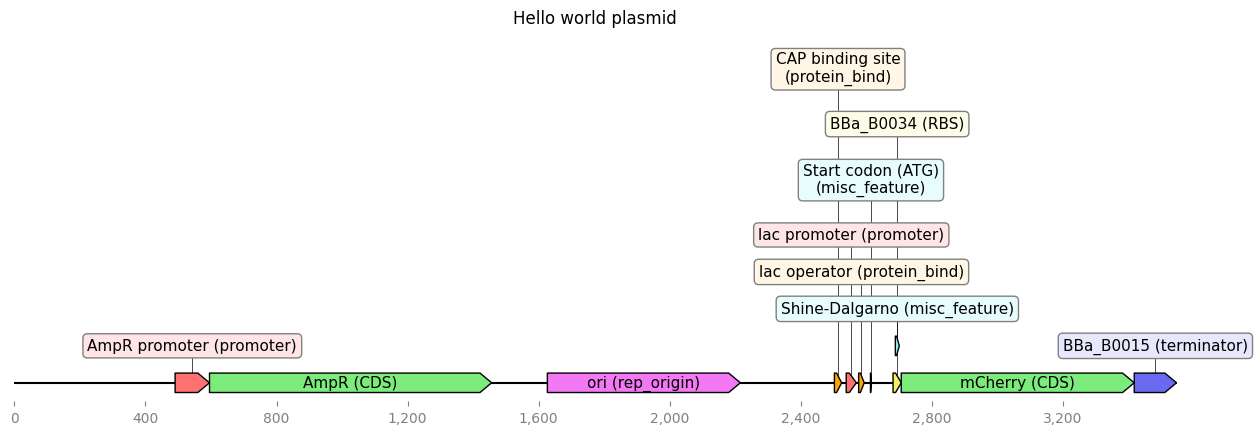

In [55]:
ax = plot_sequence(final_construct, view_as_cycle=False)
ax.set_title("Hello world plasmid");

In [56]:
print("Backbone sequence:")
print(backbone.seq)

Backbone sequence:
GAGATACCTACAGCGTGAGCTATGAGAAAGCGCCACGCTTCCCGAAGGGAGAAAGGCGGACAGGTATCCGGTAAGCGGCAGGGTCGGAACAGGAGAGCGCACGAGGGAGCTTCCAGGGGGAAACGCCTGGTATCTTTATAGTCCTGTCGGGTTTCGCCACCTCTGACTTGAGCGTCGATTTTTGTGATGCTCGTCAGGGGGGCGGAGCCTATGGAAAAACGCCAGCAACGCGGCCTTTTTACGGTTCCTGGCCTTTTGCTGGCCTTTTGCTCACATGTTCTTTCCTGCGTTATCCCCTGATTCTGTGGATAACCGTATTACCGCCTTTGAGTGAGCTGATACCGCTCGCCGCAGCCGAACGACCGAGCGCAGCGAGTCAGTGAGCGAGGAAGCGGAAGAGCGCCCAATACGCAAACCGCCTCTCCCCGCGCGTTGGCCGATTCATTAATGCAGCTGGCACGACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAATGTGAGTTAGCTCACTCATTAGGCACCCCAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGGAATTGTGAGCGGATAACAATTTCACACAGGAAACAGCTATGACCATGATTACGCCAAGCTTGCATGCCTGCAGGTCGACTCTAGAGGATCCCCGGGTACCGAGCTCGAATTCACTGGCCGTCGTTTTACAACGTCGTGACTGGGAAAACCCTGGCGTTACCCAACTTAATCGCCTTGCAGCACATCCCCCTTTCGCCAGCTGGCGTAATAGCGAAGAGGCCCGCACCGATCGCCCTTCCCAACAGTTGCGCAGCCTGAATGGCGAATGGCGCCTGATGCGGTATTTTCTCCTTACGCATCTGTGCGGTATTTCACACCGCATATGGTGCACTCTCAGTACAATCTGCTCTGATGCCGCATAGTTAAGCCAGCCCCGACACCCGCCAACACCCGCTGACGCGCCCT

In [57]:
print("Insert sequence (already with homology arms):")
x = str(insert.seq).upper()
print(x)

Insert sequence (already with homology arms):
ATCCCCGGGTACCGAGCTCGTCTAGAGAAAGAGGAGAAATACTAGATGGTGAGCAAGGGCGAGGAGGATAACATGGCCATCATCAAGGAGTTCATGCGCTTCAAGGTGCACATGGAGGGCTCCGTGAACGGCCACGAGTTCGAGATCGAGGGCGAGGGCGAGGGCCGCCCCTACGAGGGCACCCAGACCGCCAAGCTGAAGGTGACCAAGGGTGGCCCCCTGCCCTTCGCCTGGGACATCCTGTCCCCTCAGTTCATGTACGGCTCCAAGGCCTACGTGAAGCACCCCGCCGACATCCCCGACTACTTGAAGCTGTCCTTCCCCGAGGGCTTCAAGTGGGAGCGCGTGATGAACTTCGAGGACGGCGGCGTGGTGACCGTGACCCAGGACTCCTCCCTGCAGGACGGCGAGTTCATCTACAAGGTGAAGCTGCGCGGCACCAACTTCCCCTCCGACGGCCCCGTAATGCAGAAGAAGACCATGGGCTGGGAGGCCTCCTCCGAGCGGATGTACCCCGAGGACGGCGCCCTGAAGGGCGAGATCAAGCAGAGGCTGAAGCTGAAGGACGGCGGCCACTACGACGCTGAGGTCAAGACCACCTACAAGGCCAAGAAGCCCGTGCAGCTGCCCGGCGCCTACAACGTCAACATCAAGTTGGACATCACCTCCCACAACGAGGACTACACCATCGTGGAACAGTACGAACGCGCCGAGGGCCGCCACTCCACCGGCGGCATGGACGAGCTGTACAAGTAACCAGGCATCAAATAAAACGAAAGGCTCAGTCGAAAGACTGGGCCTTTCGTTTTATCTGTTGTTTGTCGGTGAACGCTCTCTACTAGAGTCACACTGGCTCACCTTCGGGTGGGCCTTTCTGCGTTTATACACTGGCCGTCGTTTTACAA


## Gibson cloning amounts

In [58]:
import pint

ureg = pint.UnitRegistry()

c_backbone_dna = 100 * ureg.ng / ureg.uL
mass_backbone_dna = 2 * ureg.ug
volume = mass_backbone_dna / c_backbone_dna
print(f"To get {mass_backbone_dna} of backbone DNA at {c_backbone_dna}, we need {volume.to("uL"):.2f}")

c_insert_dna = 10 * ureg.ng / ureg.uL
mass_insert_dna = 1000 * ureg.nanogram
volume_insert = mass_insert_dna / c_insert_dna
print(f"To get {mass_insert_dna} of insert DNA at {c_insert_dna}, we need {volume_insert.to("uL"):.2f}")


To get 2 microgram of backbone DNA at 100.0 nanogram / microliter, we need 20.00 microliter
To get 1000 nanogram of insert DNA at 10.0 nanogram / microliter, we need 100.00 microliter


---
**License**: © 2025 Matthias Függer and Thomas Nowak. Licensed under [CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/).